<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/incrementalLearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_

### DATA LOADER

In [2]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### NETWORK

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def addOutputNodes(self, num_new_outputs):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + num_new_outputs)

        #xavier initialization
        xavier_uniform_(self.fc.weight)

        #kaiming initialization
        # kaiming_uniform_(self.fc.weight)
        self.fc.weight.data[:out_features] = weight
        


def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

In [4]:
net = resnet32()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### LOSS & PARAMETERS

In [5]:
lr = 0.01
decay = 0.0001
epochs = 10
momentum = 0.9
factor = 5

In [6]:
import torch.optim as optim
import torch.nn as nn

bceLoss = nn.BCELoss()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### TRAINING

In [7]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  distillation_loss = 0

  old_net = copy.deepcopy(network)

  if (iteration != 0):
    # add 10 output nodes to the network
    network.addOutputNodes(num_classes)
    network.to(device)

  
  
  #train the network
  for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs = data[0].to(device)
      labels = data[1].to(device)
      
      # Sets the gradients of all optimized torch.Tensor to zero.
      optimizer.zero_grad() 

      # forward: assign weights to each edge in each layer
      outputs = network.forward(inputs) 
     
       # calculate the classification loss only for the new classes
       # from num_classes*iteration to num_classes*iteration+num_classes
      # start = num_classes*iteration
      # end = num_classes*iteration + num_classes
      # outputs = outputs[:,start:end]
  
      # classification_loss = criterion(outputs,labels) 
      

      if (iteration > 0):
      # calculate the distillation loss only for the old classes
        out_old = torch.sigmoid(old_net.forward(inputs))
        out_old_new = torch.argmax(out_old, dim=1)
        # print("outputs shape is: ", outputs.shape)
        # print("out_old_new is: ", out_old_new.shape)
        distillation_loss = criterion(outputs[:,0:(num_classes*iteration)], out_old_new) 
      
      # labels 128*1
      # out_old_new 128*1
      



     
      

      loss = classification_loss + distillation_loss

      # redesign the weights evaluating the performance of the network
      loss.backward() 

      # update parameters
      optimizer.step()  

      running_loss += loss.item()

      # print every 20 mini-batches the average value of the loss accumulated in each batch
      if i % 20 == 19:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

In [8]:
 def dist_loss(outputs, old_net, inputs):
    out_old = torch.sigmoid(old_net.forward(inputs))
    out_old_new = torch.argmax(out_old, dim=1)
    distillation_loss = criterion(outputs, out_old_new)
    return distillation_loss

### TRAINING BCE LOSS

In [9]:
# def training(trainloader, iteration, network, device, epochs, num_classes):
#   num_classes_till_previous_step = iteration * num_classes
#   total_classes = num_classes_till_previous_step + num_classes
#   distillation_loss = 0
  
#   if (iteration != 0):
#     # add 10 output nodes to the network
#     network.addOutputNodes(num_classes)
#     network.to(device)

#   old_net = copy.deepcopy(network)

  
#   #train the network
#   for epoch in range(epochs):

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):

#       inputs = data[0].to(device)
#       labels = data[1].to(device)
      
#       # Sets the gradients of all optimized torch.Tensor to zero.
#       optimizer.zero_grad() 

#       # forward: assign weights to each edge in each layer
#       logits = network.forward(inputs)
#       classification_loss = criterion(logits, labels)

#       if iteration > 0:
#         logits_old = torch.sigmoid(old_net(inputs))
#         distilled_old = get_one_hot(labels, total_classes, device)
#         output = logits_old[:, 0:num_classes_till_previous_step]
#         distillation_loss = bceLoss(output, distilled_old)
    

#       loss = classification_loss + distillation_loss
      
#       # redesign the weights evaluating the performance of the network
#       loss.backward() 

#       # update parameters
#       optimizer.step()  

#       running_loss += loss.item()

#       # print every 20 mini-batches the average value of the loss accumulated in each batch
#       if i % 20 == 19:    
#         print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
#         running_loss = 0.0

In [10]:
# from torch.autograd import Variable
# import torch.nn.functional as F

# def training(trainloader, iteration, network, device, epochs, num_classes):
#   num_classes_till_previous_step = iteration * num_classes
#   total_classes = num_classes_till_previous_step + num_classes
#   distillation_loss = 0
  
#   if (iteration != 0):
#     # add 10 output nodes to the network
#     network.addOutputNodes(num_classes)
#     network.to(device)

#   old_net = copy.deepcopy(network)

  
#   #train the network
#   for epoch in range(epochs):

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):

#       inputs = data[0].to(device)
#       labels = data[1].to(device)
      
#       # Sets the gradients of all optimized torch.Tensor to zero.
#       optimizer.zero_grad() 
#       q = torch.zeros(len(trainloader), total_classes).to(device)
#       # forward: assign weights to each edge in each layer
#       logits = network.forward(inputs)
#       classification_loss = criterion(logits, labels)
#       indices = i
#       q[indices] = logits.data
#       q = Variable(q).to(device)

#       # Distilation loss for old classes
#       if iterations > 0:
#         logits = F.sigmoid(logits)
#         q_i = q[indices]
#         distillation_loss = sum(bceLoss(g[:,y], q_i[:,y]) for y in xrange(num_classes_till_previous_step))

#       loss = classification_loss + distillation_loss
      
#       # redesign the weights evaluating the performance of the network
#       loss.backward() 

#       # update parameters
#       optimizer.step()  

#       running_loss += loss.item()

#       # print every 20 mini-batches the average value of the loss accumulated in each batch
#       if i % 20 == 19:    
#         print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
#         running_loss = 0.0

In [11]:
def get_one_hot(target,num_class, device):
  one_hot=torch.zeros(target.shape[0],num_class).to(device)
  one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
  return one_hot

### TEST

In [12]:
"""
def test(testloader, iteration, network, acc):

  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
        
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))
  """

'\ndef test(testloader, iteration, network, acc):\n\n  correct = 0\n  total = 0\n  print("ITERATION: ", iteration)\n  \n  # since we\'re not training, we don\'t need to calculate the gradients for our outputs\n  with torch.no_grad():\n      for data in testloader:\n          images, labels = data[0].to(device), data[1].to(device)\n\n          # calculate outputs by running images through the network\n          outputs = network.forward(images)\n\n          # the class with the highest energy is what we choose as prediction\n          _, predicted = torch.max(outputs.data, 1)\n          total += labels.size(0)\n          correct += (predicted == labels).sum().item()\n         \n        \n  acc.append(100*correct/total)\n  print(f\'Accuracy of the network on the {iteration} iteration: %d %%\' % (100 * correct / total))\n  '

### EXECUTION 

In [13]:
"""
# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations= 10 
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = [] 
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time

  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration
  """

'\n# divided our dataset into sample of 10 classes each\n# train the network on the first 10 classes\n# evaluate the network on the first 10 classes\n# train the network on the second 10 classes (adding 10 output layers)\n# evaluate the network on the first 20 classes\niterations= 10 \nnum_classes = 10\ntest_set = [] #initialized here because we test over all the classes not only those one in which I train\nacc = []\nimport random\n#indices = list(range(0,100))\n#random.shuffle(indices)\nfor i in range(iterations):\n  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)\n  train_iter = [] \n  for j in range(len(trainset)):\n    if(trainset[j][-1] in classes_current_iter):\n      test_set.append(trainset[j]) \n      train_iter.append(trainset[j])\n\n\n  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)\n  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2

### CONFUSION MATRIX

In [14]:
"""
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
"""

'\nfrom sklearn.metrics import plot_confusion_matrix\nimport matplotlib.pyplot as plt\n\nconfusion_matrix = torch.zeros(100,100)\n\ncorrect = 0\ntotal = 0\n# since we\'re not training, we don\'t need to calculate the gradients for our outputs\nwith torch.no_grad():\n    for data in valid_loader:\n        images, labels = data[0].to(device), data[1].to(device)\n        # calculate outputs by running images through the network\n        outputs = net.forward(images)\n        # the class with the highest energy is what we choose as prediction\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n        for t, p in zip(labels.view(-1), predicted.view(-1)):\n          confusion_matrix[t.long(),p.long()] += 1\n\nplt.figure()\nplt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)\nprint(\'Accuracy of the network on the 10000 test images: %d %%\' % (100 * correct / total))\n'

### TEST (CONFUSION EACH STEP)



In [15]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network, acc):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
  plt.show()
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

### RANDOM CLASSES


EXECUTION

In [16]:
import random
indices = list(range(0,100))
random.shuffle(indices)
dict_classes = dict(zip(indices,range(100)))
for i in range(len(trainset)):
  trainset[i][1] = dict_classes[trainset[i][1]]

Train the network, iteration:  0  on classes:  range(0, 10)
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs before operation shape is:  torch.Size([128, 10])
outputs befo

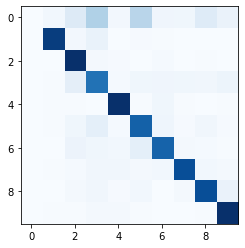

Accuracy of the network on the 0 iteration: 76 %
Train the network, iteration:  1  on classes:  range(10, 20)
outputs before operation shape is:  torch.Size([128, 20])


RuntimeError: ignored

In [17]:
#TRYING TO RANDOMIZE CLASSES


# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
#import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  #classes_current_iter = dict(zip(indices[i*num_classes : i*num_classes+num_classes],range(i*num_classes,i*num_classes+num_classes)))
  # print(classes_current_iter)
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])

  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time
  #print("Train_loader length: ",len(train_loader))
  #print("valid_loader length: ",len(valid_loader))
  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration